In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [2]:
df=pd.read_csv('orders.csv')

In [3]:
df

,order_id,user_id,order_timestamp,city,cuisine,paid_cash,amount
0,7322173742136,94223136441,2022-01-18 15:41:28 UTC,Αίγιο,Breakfast,True,3.6
1,7210978616924,204794985423,2022-01-02 17:50:50 UTC,Αγρίνιο,Breakfast,True,1.9
2,7221232906132,12703920390,2022-01-04 08:37:12 UTC,Αγρίνιο,Breakfast,True,1.7
3,7399605199800,673310109528,2022-01-31 11:33:05 UTC,Λιβαδειά,Breakfast,True,3.0
4,7264221279744,673310109528,2022-01-10 11:18:28 UTC,Λιβαδειά,Breakfast,True,3.0
...,...,...,...,...,...,...,...
534265,7383295241752,314285338626,2022-01-28 22:25:04 UTC,Αλεξανδρούπολη,Street food,True,11.9
534266,7383425578320,586121418057,2022-01-28 22:39:29 UTC,Αλεξανδρούπολη,Street food,True,9.9
534267,7364485291992,29082002418,2022-01-24 19:29:34 UTC,Αλεξανδρούπολη,Street food,True,15.1
534268,7231345759480,348528607896,2022-01-05 18:28:41 UTC,Αλεξανδρούπολη,Street food,True,14.7


In [4]:
df.columns

Index(['order_id', 'user_id', 'order_timestamp', 'city', 'cuisine',
       'paid_cash', 'amount'],
      dtype='object')

In [5]:
df.isna().sum()

order_id           0
user_id            0
order_timestamp    0
city               0
cuisine            0
paid_cash          0
amount             0
dtype: int64

In [6]:
df.dtypes

order_id             int64
user_id              int64
order_timestamp     object
city                object
cuisine             object
paid_cash             bool
amount             float64
dtype: object

## RFM Analysis

In [7]:
# Calculate Recency
df['order_timestamp'] = pd.to_datetime(df['order_timestamp'])
max_date = df['order_timestamp'].max()
df['recency'] = (max_date - df['order_timestamp']).dt.days

In [8]:
# Calculate Frequency
frequency_df = df.groupby('user_id')['order_id'].nunique().reset_index()
frequency_df.columns = ['user_id', 'frequency']

In [9]:
# Calculate Monetary
monetary_df = df.groupby('user_id')['amount'].sum().reset_index()
monetary_df.columns = ['user_id', 'monetary']

In [10]:
# Merge the metrics
rfm_df = pd.merge(frequency_df, monetary_df, on='user_id')

In [11]:
rfm_df = pd.merge(df.drop_duplicates(subset='user_id'), rfm_df, on='user_id')

In [12]:
rfm_df

,order_id,user_id,order_timestamp,city,cuisine,paid_cash,amount,recency,frequency,monetary
0,7322173742136,94223136441,2022-01-18 15:41:28+00:00,Αίγιο,Breakfast,True,3.60,13,11,103.60
1,7210978616924,204794985423,2022-01-02 17:50:50+00:00,Αγρίνιο,Breakfast,True,1.90,29,7,30.50
2,7221232906132,12703920390,2022-01-04 08:37:12+00:00,Αγρίνιο,Breakfast,True,1.70,27,21,35.70
3,7399605199800,673310109528,2022-01-31 11:33:05+00:00,Λιβαδειά,Breakfast,True,3.00,0,8,23.90
4,7290656850956,212289897372,2022-01-14 10:49:34+00:00,Λαμία,Breakfast,False,3.00,17,22,110.00
...,...,...,...,...,...,...,...,...,...,...
121938,7360460735324,551306802291,2022-01-23 20:27:15+00:00,Αλεξανδρούπολη,Street food,True,10.35,8,1,10.35
121939,7254089665388,74723220264,2022-01-08 21:17:19+00:00,Αλεξανδρούπολη,Street food,True,25.10,23,1,25.10
121940,7315347998008,67756053414,2022-01-17 15:19:51+00:00,Αλεξανδρούπολη,Street food,True,17.80,14,1,17.80
121941,7258947193332,181885879896,2022-01-09 16:09:21+00:00,Αλεξανδρούπολη,Street food,True,18.40,22,1,18.40


In [13]:
rfm_df=rfm_df.drop(['paid_cash'], 1)

In [14]:
# Segmentation based on quantiles
quantiles = rfm_df.quantile(q=[0.25, 0.50, 0.75])
rfm_df['R_score'] = pd.qcut(rfm_df['recency'], q=[0, 0.25, 0.5, 0.75, 1], labels=False)
rfm_df['F_score'] = pd.qcut(rfm_df['frequency'], q=[0, 0.25, 0.5, 0.75, 1], labels=False, duplicates='drop')
rfm_df['M_score'] = pd.qcut(rfm_df['monetary'], q=[0, 0.25, 0.5, 0.75, 1], labels=False)


In [15]:
# Create RFM segments
rfm_df['RFM_segment'] = rfm_df['R_score'].astype(str) + rfm_df['F_score'].astype(str) + rfm_df['M_score'].astype(str)

In [16]:
rfm_df

,order_id,user_id,order_timestamp,city,cuisine,amount,recency,frequency,monetary,R_score,F_score,M_score,RFM_segment
0,7322173742136,94223136441,2022-01-18 15:41:28+00:00,Αίγιο,Breakfast,3.60,13,11,103.60,1,2,3,123
1,7210978616924,204794985423,2022-01-02 17:50:50+00:00,Αγρίνιο,Breakfast,1.90,29,7,30.50,3,2,2,322
2,7221232906132,12703920390,2022-01-04 08:37:12+00:00,Αγρίνιο,Breakfast,1.70,27,21,35.70,3,2,2,322
3,7399605199800,673310109528,2022-01-31 11:33:05+00:00,Λιβαδειά,Breakfast,3.00,0,8,23.90,0,2,2,022
4,7290656850956,212289897372,2022-01-14 10:49:34+00:00,Λαμία,Breakfast,3.00,17,22,110.00,2,2,3,223
...,...,...,...,...,...,...,...,...,...,...,...,...,...
121938,7360460735324,551306802291,2022-01-23 20:27:15+00:00,Αλεξανδρούπολη,Street food,10.35,8,1,10.35,0,0,0,000
121939,7254089665388,74723220264,2022-01-08 21:17:19+00:00,Αλεξανδρούπολη,Street food,25.10,23,1,25.10,2,0,2,202
121940,7315347998008,67756053414,2022-01-17 15:19:51+00:00,Αλεξανδρούπολη,Street food,17.80,14,1,17.80,1,0,1,101
121941,7258947193332,181885879896,2022-01-09 16:09:21+00:00,Αλεξανδρούπολη,Street food,18.40,22,1,18.40,2,0,1,201


In [17]:
# Define the conditions for each segment
conditions = [
    (rfm_df['F_score'] >= 2) & (rfm_df['R_score'] >= 2) & (rfm_df['M_score'] >= 2),
    (rfm_df['F_score'] >= 2) & (rfm_df['R_score'] <= 2),
    (rfm_df['frequency'] == 1)
]

# Define the corresponding labels for each segment
labels = [
    'Best Customers',
    'Used to be loyal Customers',
    'One-time Customers'
]

# Assign the 'Regular customers' label to all other segments
default_label = 'Regular Customers'

# Create the 'Segments' column based on the conditions and labels
rfm_df['Customer_segment'] = np.select(conditions, labels, default_label)

## Visualizations

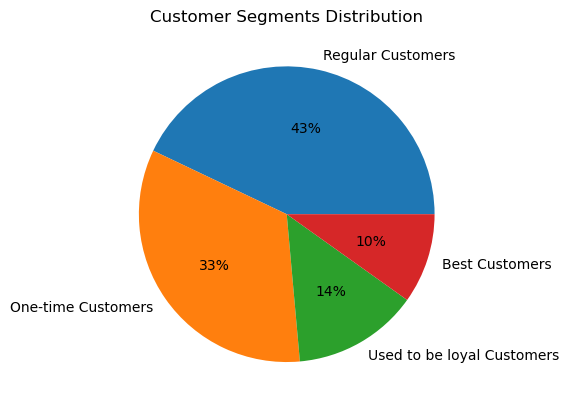

In [18]:
# Create a pie chart showing the customer segments distribution
plt.pie(rfm_df.Customer_segment.value_counts(), labels=rfm_df.Customer_segment.value_counts().index, autopct='%.0f%%')
plt.title('Customer Segments Distribution')
fig = plt.gcf()
fig.set_facecolor('none')  # Set the figure background color to transparent
plt.show()

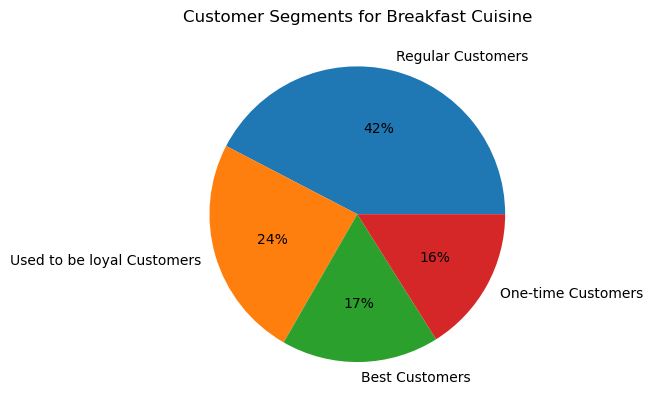

In [19]:
# Filter the DataFrame for "Breakfast" cuisine
breakfast_df = rfm_df[rfm_df['cuisine'] == 'Breakfast']

# Create a pie chart showing the customer segments distribution for "Breakfast" cuisine
plt.pie(breakfast_df['Customer_segment'].value_counts(), labels=breakfast_df['Customer_segment'].value_counts().index, autopct='%.0f%%')
plt.title('Customer Segments for Breakfast Cuisine')

fig = plt.gcf()
fig.set_facecolor('none')  # Set the figure background color to transparent
plt.show()

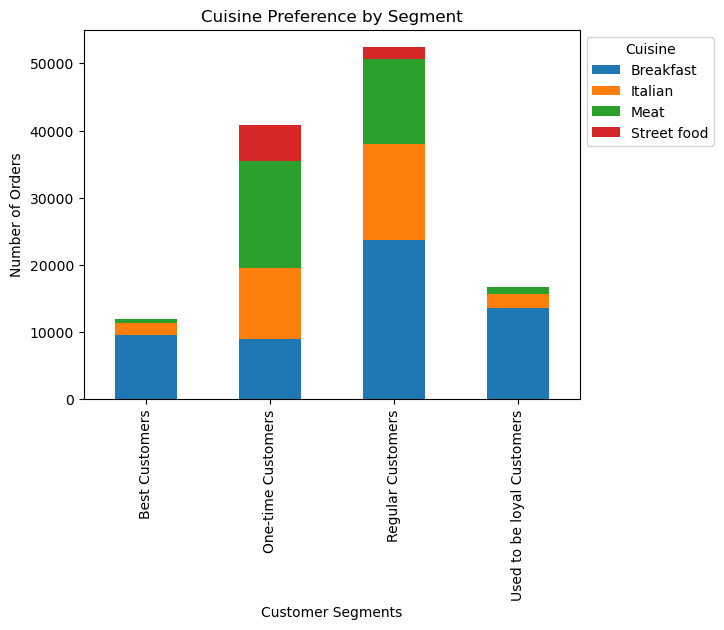

In [20]:
# Group the data by customer segment and cuisine, and calculate the count of orders instead of the sum
segment_cuisine_orders = rfm_df.groupby(['Customer_segment', 'cuisine'])['order_id'].count().unstack()

# Plot the bar plot showing cuisine preference by segment
ax = segment_cuisine_orders.plot(kind='bar', stacked=True)
plt.xlabel('Customer Segments')
plt.ylabel('Number of Orders')
plt.title('Cuisine Preference by Segment')
plt.legend(title='Cuisine', bbox_to_anchor=(1, 1), loc='upper left')

fig = plt.gcf()
fig.set_facecolor('none')  # Set the figure background color to transparent
plt.show()

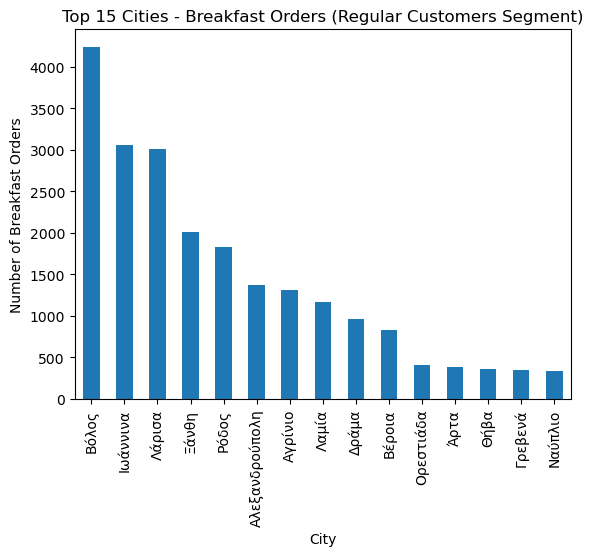

In [23]:
# Filter the DataFrame for Regular Customers Segment
filtered_df = rfm_df[rfm_df['Customer_segment']=='Regular Customers']

# Filter further for orders with "Breakfast" cuisine
filtered_df = filtered_df[filtered_df['cuisine'] == 'Breakfast']

# Calculate the number of breakfast orders for each city
city_breakfast_orders = filtered_df['city'].value_counts()

# Select the top 15 cities based on breakfast orders
top_15_cities = city_breakfast_orders.head(15)

# Plot the number of breakfast orders for the top 15 cities
top_15_cities.plot(kind='bar')
plt.xlabel('City')
plt.ylabel('Number of Breakfast Orders')
plt.title('Top 15 Cities - Breakfast Orders (Regular Customers Segment)')

fig = plt.gcf()
fig.set_facecolor('none')  # Set the figure background color to transparent
plt.show()

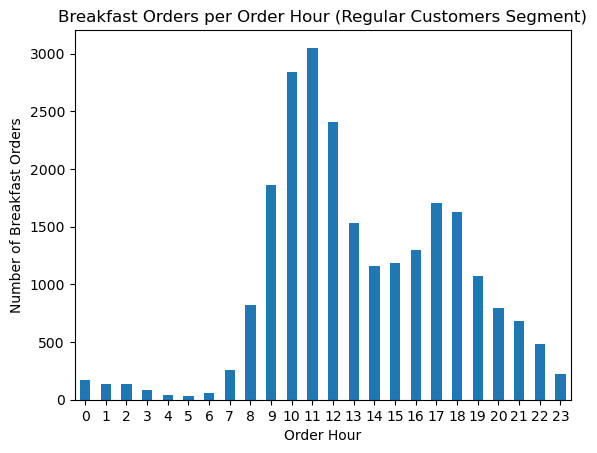

In [24]:
# Filter the DataFrame for Regular Customers Segment
filtered_df = rfm_df[rfm_df['Customer_segment']=='Regular Customers']

# Filter further for orders with "Breakfast" cuisine
filtered_df = filtered_df[filtered_df['cuisine'] == 'Breakfast']

# Extract the hour from the order_timestamp column
filtered_df['order_hour'] = filtered_df['order_timestamp'].dt.hour

# Calculate the number of breakfast orders for each order hour
order_hour_counts = filtered_df['order_hour'].value_counts().sort_index()

# Plot the number of breakfast orders per order hour
order_hour_counts.plot(kind='bar')
plt.xlabel('Order Hour')
plt.ylabel('Number of Breakfast Orders')
plt.title('Breakfast Orders per Order Hour (Regular Customers Segment)')
plt.xticks(rotation=0)

fig = plt.gcf()
fig.set_facecolor('none')  # Set the figure background color to transparent
plt.show()